In [1]:
import numpy as np
import pandas as pd

import os, glob

from collections import OrderedDict

import matplotlib
import matplotlib.pyplot as plt

import ipywidgets as widgets
from traitlets import dlink
from IPython.display import display

from pyrixs import process2d

%matplotlib nbagg

In [2]:
global Image
Image = OrderedDict({
'photon_events' : np.array([]),
'background' : np.array([]),
'raw_image' : np.array([]),
'name' : '',
'curvature' : np.array([1.4400754935337945e-7, 0.007263554392365014, 500]),
'image_meta' : '',
'spectrum' : np.array([])
})

In [3]:
######################################
# Widgets
######################################

# Folder to search images for
images_folder_widget = widgets.Text(
    value='test_images/*.nxs',  
    description='Search path',
    width='500px',
)

# Folder to search background for
bkg_folder_widget = widgets.Text(
    value='test_images/*.nxs',  
    description='Search path',
    width='500px',
)

# Display and pick spectra
select_images_widget = widgets.Select(
            options=process2d.get_all_image_names(images_folder_widget.value),
            description='Select images'
            )

# Display and pick bkg
select_bkg_widget = widgets.Select(
            options=process2d.get_all_image_names(bkg_folder_widget.value),
            description='Select background'
            )
# Select with image to plot
select_plot_widget = widgets.Select(
            options=['Raw image', 'Background', 'Background removed Image'],
            description='Select option'
            )

display_image_button = widgets.Button(
    description='Plot',
)

# Initialize values for background removal
threshold_widget = widgets.FloatText(description='Threshold', value=1e6)
sig1_widget = widgets.FloatText(description='Sigma 1', value=100)
sig2_widget = widgets.FloatText(description='Sigma 2', value=100)
sig3_widget = widgets.FloatText(description='Sigma 3', value=100)

# Select which background removal to use
select_clean_widget = widgets.Select(
            options=['Threshold', 'Standard Deviation'],
            description='Select cleaning method'
            )

load_clean_button = widgets.Button(
    description='Load and clean data',
)


rejected_pixel_widget = widgets.Textarea(description='Rejected pixels', value='Image: 0.00%\nBackground: 0.00%')

display_imagecurv_button = widgets.Button(
    description='Plot',
)

x2_widget = widgets.FloatText(description='x^2', value=Image['curvature'][0])
x1_widget = widgets.FloatText(description='x^1', value=Image['curvature'][1])
x0_widget = widgets.FloatText(description='x^0', value=Image['curvature'][2])

fit_curvature_button = widgets.Button(
    description='Fit',
)

plot_resolution_button = widgets.Button(
    description='Plot',
)

names = ['FWHM', 'center', 'amplitude', 'offset']
values = [3., 100., 10, 0.]
params_widget = widgets.HBox([widgets.FloatText(description=name, value=value, width='150px') 
                              for name, value in zip(names, values)])

fit_resolution_button = widgets.Button(
    description='Fit',
)

In [4]:
###########################
## Widget logic
###########################
def update_select_images_widget(change):
    """Refresh images for selection"""
    select_images_widget.options = process2d.get_all_image_names(images_folder_widget.value)
    
images_folder_widget.on_submit(update_select_images_widget)

def update_select_bkg_widget(change):
    """Refresh images for selection"""
    select_bkg_widget.options = process2d.get_all_image_names(bkg_folder_widget.value)
    
bkg_folder_widget.on_submit(update_select_bkg_widget)

def wrap_load_clean(change):
        
    Image['raw_image'] = process2d.load_photon_events(images_folder_widget.value,
                                                      select_images_widget.value)
    
    Image['background'] = process2d.load_photon_events(bkg_folder_widget.value,
                                                       select_bkg_widget.value)
    
    ###Each data file has three images, but background only one!!!! ###
    Image['background'][:,2] *= 3.0
    
    if select_clean_widget.value == 'Threshold':
        thHigh = threshold_widget.value
        Image['raw_image'], im_pixels = process2d.clean_image_threshold(Image['raw_image'], thHigh)
        Image['background'], bkg_pixels = process2d.clean_image_threshold(Image['background'], thHigh)
        
    elif select_clean_widget.value == 'Standard Deviation':
        sig1 = sig1_widget.value
        sig2 = sig2_widget.value
        sig3 = sig3_widget.value
        Image['raw_image'], im_pixels = process2d.clean_image_std(Image['raw_image'], [sig1,sig2,sig3], Image['curvature'])
        Image['background'], bkg_pixels = process2d.clean_image_std(Image['background'], [sig1,sig2,sig3], Image['curvature'])
    
    Image['photon_events'] = np.copy(Image['raw_image'])
    Image['photon_events'][:,2] -= Image['background'][:,2]
    
    rejected_pixel_widget.value = 'Image: {:.2f}%\nBackground: {:.2f}%'.format(im_pixels*100.,bkg_pixels*100.)

    Image['raw_image'] = Image['raw_image'][np.isfinite(Image['raw_image'][:,2]),:]
    Image['background'] = Image['background'][np.isfinite(Image['background'][:,2]),:]
    Image['photon_events'] = Image['photon_events'][np.isfinite(Image['photon_events'][:,2]),:]
    
load_clean_button.on_click(wrap_load_clean)

def wrap_display_image(change):
    """Load and plot images and curvature"""
    
    fig1.clf()
    plt.figure(fig1.number)
    ax1 = plt.gca()
    ax1.hold(False)
    
    if Image['raw_image'].shape == (0,):
        raise ValueError('Image is not loaded!')
    
    if select_plot_widget.value == 'Raw image':
        im_plot = np.copy(Image['raw_image'])
    elif select_plot_widget.value == 'Background':
        im_plot = np.copy(Image['background'])
    elif select_plot_widget.value == 'Background removed Image':
        im_plot = np.copy(Image['photon_events'])
        
    if select_images_widget.value[-3:] == 'nxs':
        image_artist = process2d.plot_imshow(ax1, im_plot)
    else:
        image_artist = process2d.plot_scatter(ax1, im_plot)
        
display_image_button.on_click(wrap_display_image)

def wrap_display_imagecurv(change):
    """Load and plot images and curvature"""
    
    fig2.clf()
    plt.figure(fig2.number)
    ax2 = plt.gca()
    ax2.hold(False)
    
    if select_images_widget.value[-3:] == 'nxs':
        image_artist = process2d.plot_imshow(ax2, Image['photon_events'])
    else:
        image_artist = process2d.plot_scatter(ax2, Image['photon_events'])
        
    process2d.plot_curvature(ax2, Image['curvature'], Image['photon_events'])

display_imagecurv_button.on_click(wrap_display_imagecurv)

def wrap_curvature(change):
    """Assign values in curvature widget to Images['curvature']"""
    Image['curvature'] = np.array([x2_widget.value, x1_widget.value, x0_widget.value])

x2_widget.observe(wrap_curvature)
x1_widget.observe(wrap_curvature)
x0_widget.observe(wrap_curvature)
    
def wrap_fit_curvature(change):
    """Fit the curvature and assign values into widgets"""
    curvature = process2d.fit_curvature(Image['photon_events'], CONSTANT_OFFSET = x0_widget.value)
    Image['curvature'] = curvature
    x2_widget.value = curvature[0]
    x1_widget.value = curvature[1]
    #print("x^2 value {}".format(curvature[0]))
    #print("x^1 value {}".format(curvature[1]))
    #print("x^0 value {}".format(curvature[2]))
    wrap_curvature(None)
    wrap_display_imagecurv(None)

fit_curvature_button.on_click(wrap_fit_curvature)        
        
def wrap_plot_resolution(change):
    """Extract the spectrum and plot it on ax2"""
    spectrum = process2d.extract(Image['photon_events'],
                                Image['curvature'])
    Image['spectrum'] = spectrum
    process2d.plot_resolution(ax3, spectrum)

plot_resolution_button.on_click(wrap_plot_resolution)

def wrap_fit_resolution(change):
    xmin, xmax, _, _ = ax3.axis()
    resolution = process2d.fit_resolution(Image['spectrum'], xmin=xmin, xmax=xmax)
    for widget, value in zip(params_widget.children, resolution):
        widget.value = value
    
    try:
        resolution_line.remove()
    except NameError:
        pass
    resolution_line, *_ = process2d.plot_resolution_fit(ax3, Image['spectrum'], resolution,
                                  xmin=xmin, xmax=xmax)

fit_resolution_button.on_click(wrap_fit_resolution)

## List and choose image

In [5]:
display(images_folder_widget, select_images_widget)

## List and choose background

In [6]:
display(bkg_folder_widget, select_bkg_widget)

## Clean and load image and background 

In [7]:
display(widgets.HBox((select_clean_widget, widgets.VBox((threshold_widget,sig1_widget,sig2_widget,sig3_widget)),load_clean_button)))

display(rejected_pixel_widget)

## Plot image and background

<IPython.core.display.Javascript object>


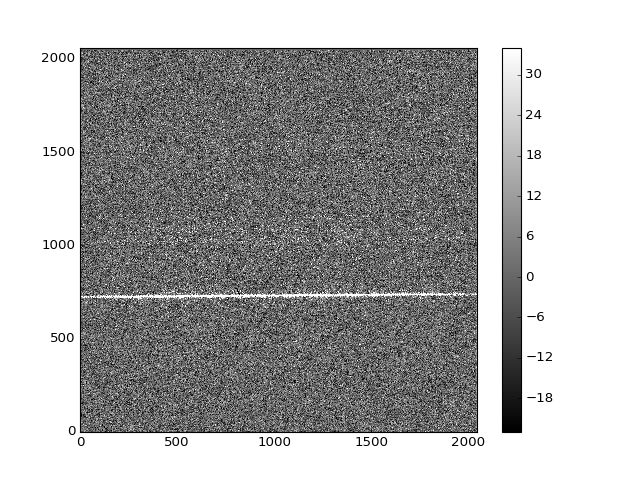

In [8]:
fig1, ax1 = plt.subplots()
ax1.hold(False)

display(widgets.HBox((select_plot_widget, display_image_button)))

## Plot image

<IPython.core.display.Javascript object>


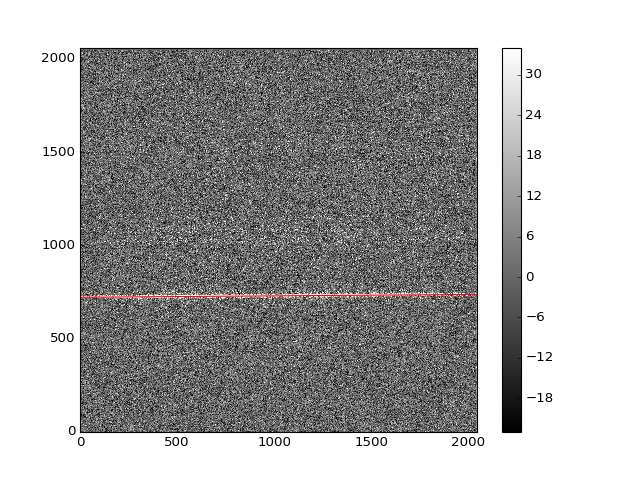

None

In [9]:
fig2, ax2 = plt.subplots()
ax2.hold(False)

display(display(widgets.HBox((x2_widget, x1_widget, x0_widget), width='50%')),
        widgets.HBox((display_imagecurv_button, fit_curvature_button)))

## Plot resolution

<IPython.core.display.Javascript object>


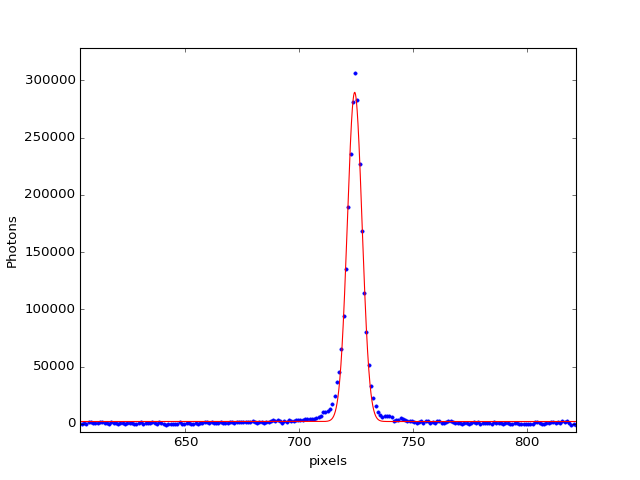

In [10]:
fig3, ax3 = plt.subplots()
ax3.hold(False)

display(params_widget)
display(widgets.HBox([plot_resolution_button, fit_resolution_button]))

In [11]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [12]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show/hide code."></form>''')